In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm

import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from scipy import optimize, stats

from nilearn import plotting, masking, image
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# import pingouin as pg

import random
# from random import random as rand

import re

In [2]:
scaler = StandardScaler()

In [3]:
%matplotlib inline

In [4]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [5]:
dir_root = join('/mnt/ext4/GL')
dir_preproc = join(dir_root,'fmri_data/preproc_data.SSKim')
dir_reg = join(dir_root,'behav_data/regressors/Reward')
dir_stat = join(dir_root,'fmri_data/stats/GLM.reward.4s_shifted.SSKim')
dir_mask = join(dir_root,'fmri_data/masks')

In [6]:
list_subj = []
for dname in glob(join(dir_preproc,'GL??')):
    list_subj.append(dname.split('/')[-1])
list_subj = sorted(list_subj)

In [7]:
pb = 'volreg'

---

In [8]:
## assign variables
df = pd.DataFrame()
dg = pd.DataFrame()
dict_reg = {}
dict_BOLD = {}

for subj in tqdm(list_subj):
    ## a convolved regressor
    xmat = np.loadtxt(
        join(dir_stat, '%s/X.nocensor.xmat.1D'%subj)
        , dtype=float, comments='#'
    )
    reg = xmat[:1200,37]
    reg = reg.reshape(1200,1)
    reg = scaler.fit_transform(reg)

    a = reg.reshape(-1)
    dict_reg[subj] = a
    
    ## Load BOLD signals
    for roi in ['caudate','putamen']:
        for area in ['la','lp','ra','rp']:
            bold = np.loadtxt(
                join(dir_stat,subj,'ts.%s.%s.%s.%s.1D'%(roi,area,subj,pb))
            )
            bold = bold.reshape(1200,1)
            bold = scaler.fit_transform(bold)
            b = bold.reshape(-1)
            dict_BOLD[(subj,roi,area)] = b

            rval, pval = stats.pearsonr(a,b)
            
            new_row = pd.Series(
                {
                    'subj':subj, 'roi':roi, 'area':area,
                    'Pearson_r':rval, 'pval':pval
                }
            )
            df = pd.concat(
                [df, new_row.to_frame().T],
                axis='index',
                ignore_index=True
            )
            
    tmp = df[df.subj==subj].Pearson_r.max()
    dg = pd.concat(
        [dg, df[df.Pearson_r==tmp]],
        axis='index',
        ignore_index=True
    )
dg

100%|██████████| 24/24 [00:01<00:00, 21.27it/s]


,subj,roi,area,Pearson_r,pval
0,GL03,caudate,ra,0.130931,0.000005
1,GL04,caudate,lp,0.136921,0.000002
2,GL05,putamen,ra,0.143899,0.000001
3,GL06,putamen,la,0.149152,0.0
4,GL07,putamen,ra,0.116785,0.00005
5,GL08,putamen,ra,0.168972,0.0
6,GL09,caudate,ra,0.194533,0.0
7,GL10,putamen,ra,0.122464,0.000021
8,GL11,putamen,la,0.142368,0.000001
9,GL12,caudate,la,0.088699,0.002102


In [9]:
df.groupby(['subj'], as_index=False).mean()

/tmp/ipykernel_2563157/169753414.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['subj'], as_index=False).mean()


,subj,Pearson_r,pval
0,GL03,0.097978,0.002601
1,GL04,0.075511,0.117198
2,GL05,0.103624,0.017255
3,GL06,0.126169,0.000088
4,GL07,0.075082,0.046572
5,GL08,0.092736,0.012270
6,GL09,0.111816,0.003889
7,GL10,0.085278,0.097879
8,GL11,0.098824,0.024042
9,GL12,0.052260,0.255464


---

In [10]:
## 4*(1+12*12)//2 = 290 time points per run
## 4 sec * 12 trials / TR = 24 time points per block
on = [1 for i in range(12*4)]
off = [-1 for i in range(12*4)]
tmp = [[0,0,1,1,1,1]] + [[*on,*off] for j in range(6)] + [[0] for i in range(18)]
tmp = np.concatenate(tmp)
s = np.concatenate([tmp for i in range(4)])[::2]

## downsampling
s = np.mean(s.reshape(-1, 2), axis=1)
len(s)

600

In [11]:
dx = len(s)*0.25
print(dx)
xticks =  np.arange(0,len(s)+1,dx).astype(int)
print(xticks)
xminorticks = np.arange(np.diff(xticks)[0]*0.5,len(s)+1,dx).astype(int)
print(xminorticks)

150.0
[  0 150 300 450 600]
[ 75 225 375 525]


100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


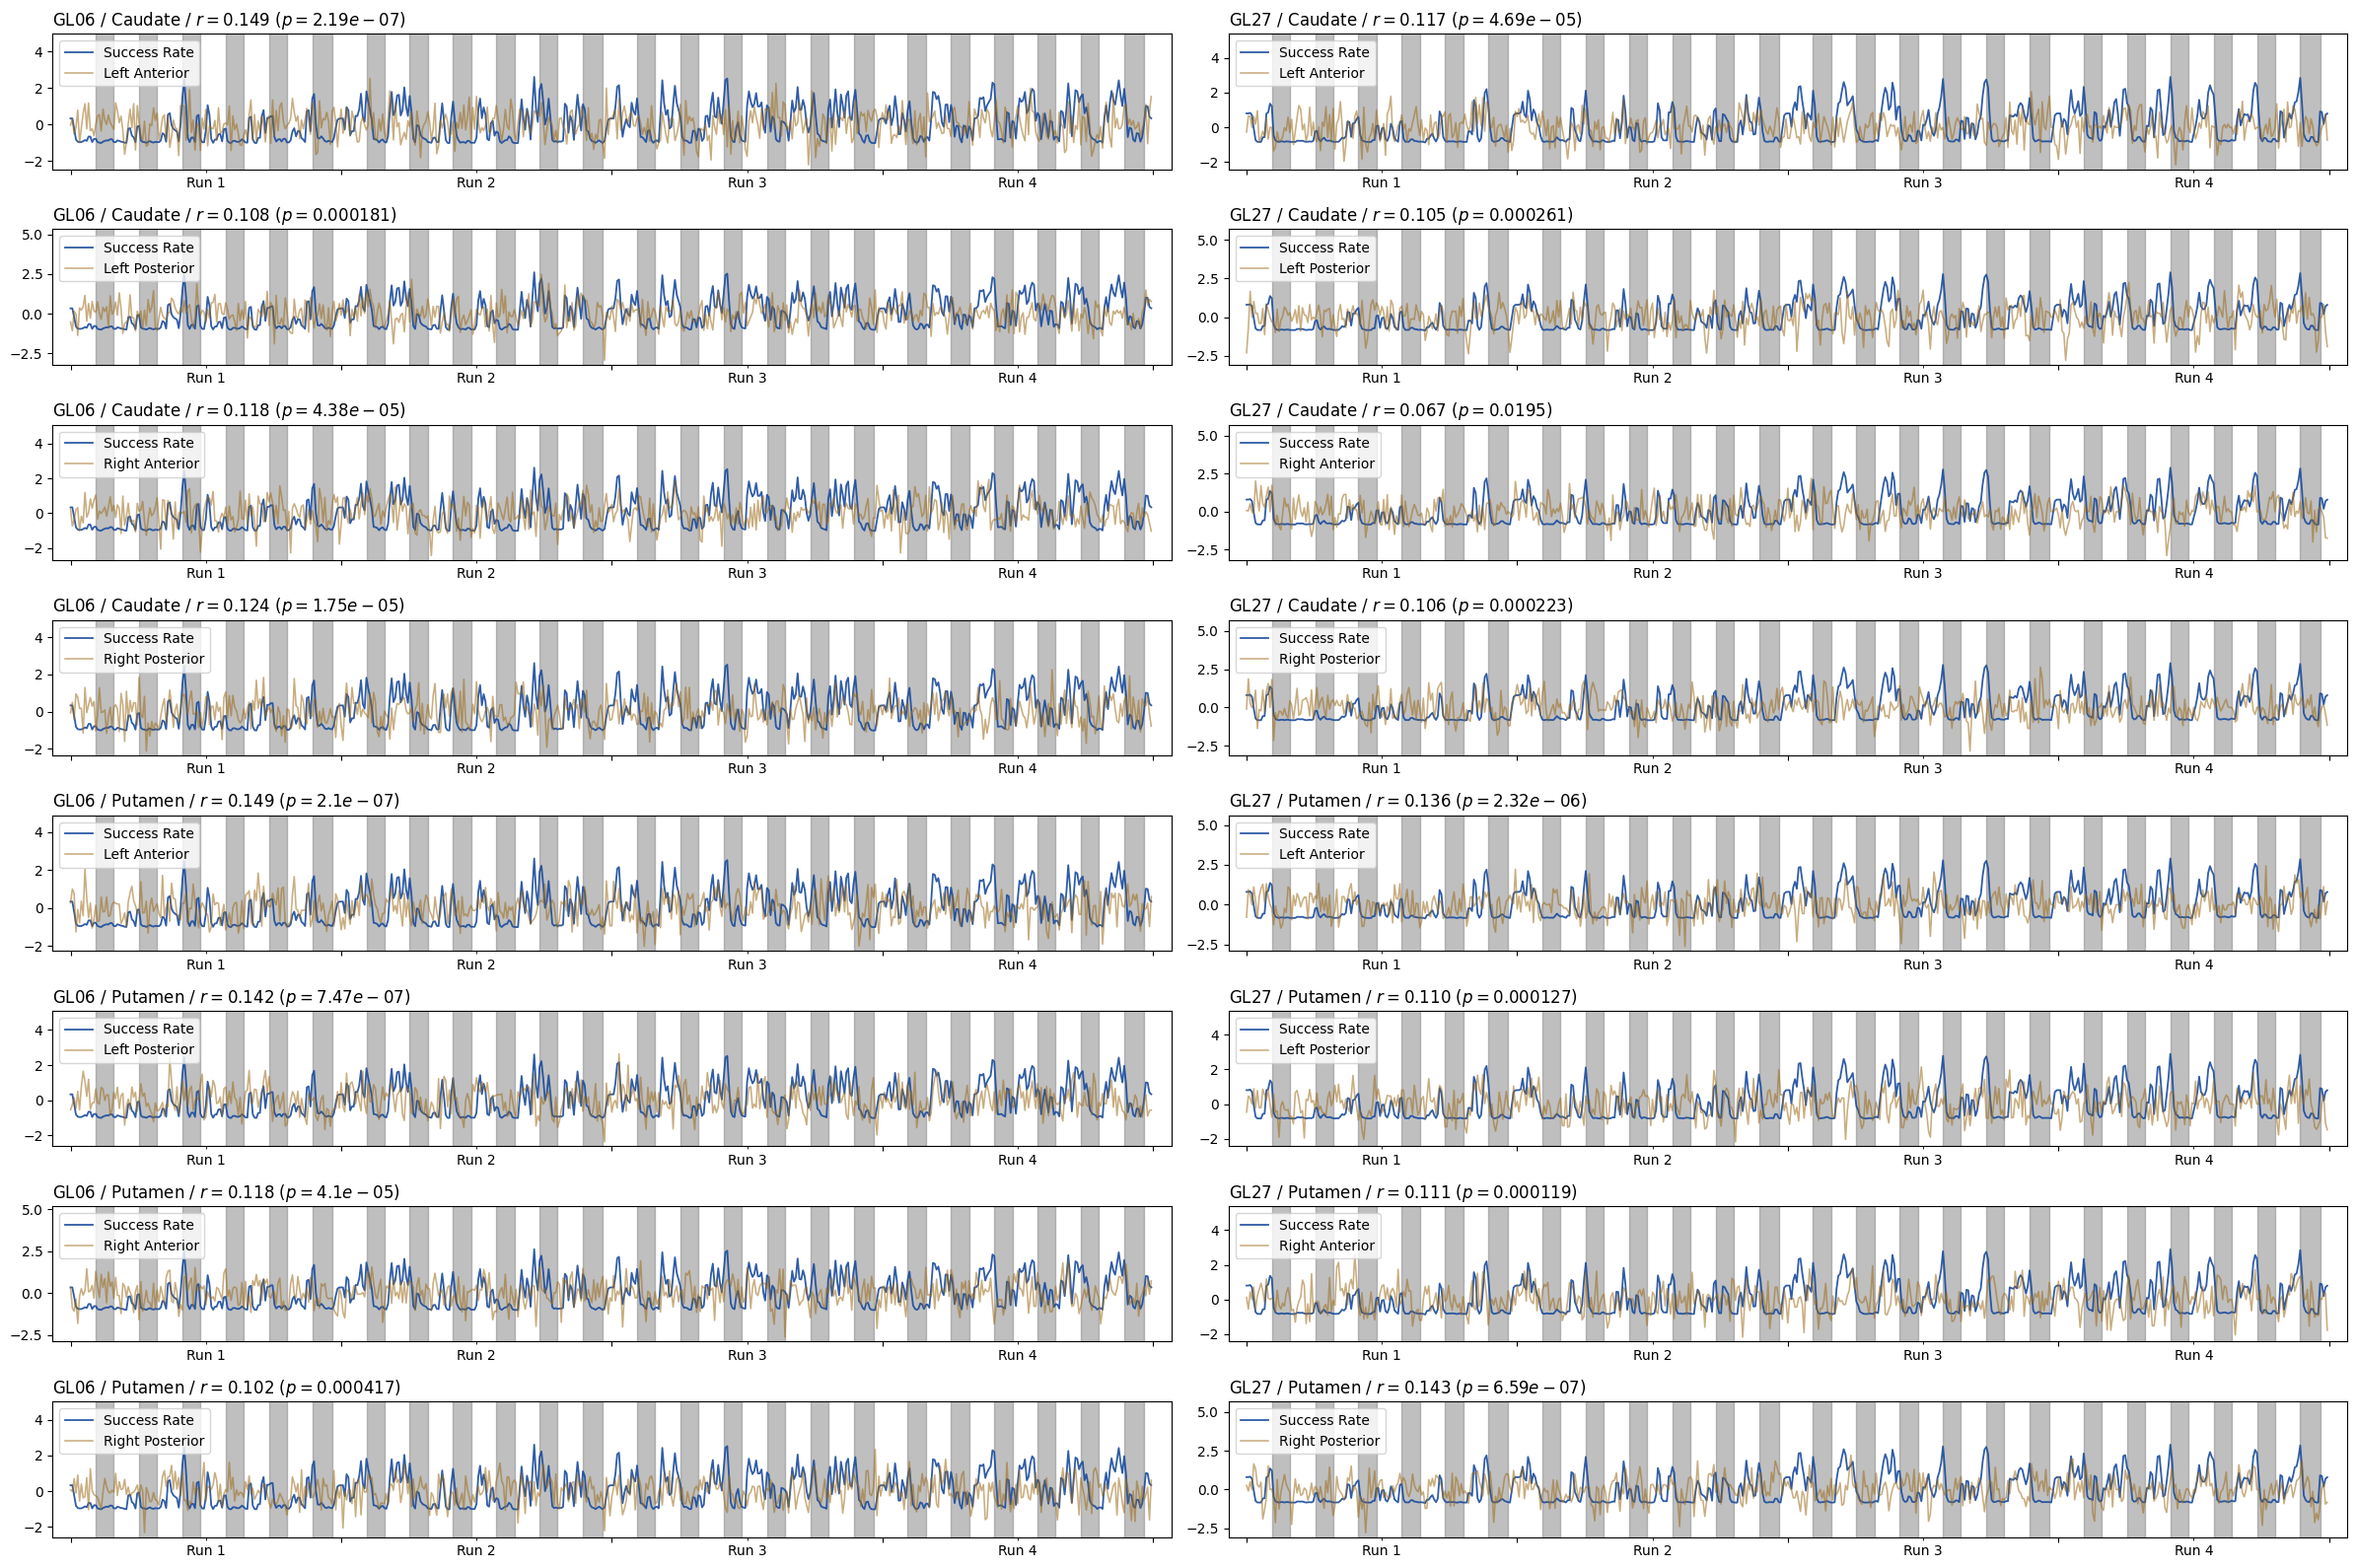

In [12]:
list_ = ['GL06', 'GL27']
ncols = len(list_)
nrows = 8
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12*ncols,2*nrows))

for ii, subj in enumerate(tqdm(list_)):
    cnt = 0
    for roi in ['caudate','putamen']:
        for area in ['la','lp','ra','rp']:
            ax = axs[cnt][ii]
            
            LR = 'Left' if area[0]=='l' else ('Right' if area[0]=='r' else 'invalid')
            AP = 'Anterior' if area[1]=='a' else ('Posterior' if area[1]=='p' else 'invalid')
            
            a = dict_reg[subj]
            ## downsampling
            a = np.mean(a.reshape(-1, 2), axis=1)
            ax.plot(
                a,
                label='Success Rate',
                linestyle='-',linewidth=1.3,
                color='#184A9C', alpha=0.9
            )
            
            b = dict_BOLD[(subj,roi,area)]
            ## downsampling
            b = np.mean(b.reshape(-1, 2), axis=1)
            ax.plot(
                b,
                label='%s %s'%(LR,AP),
                linestyle='-', linewidth=1.15,
                color='#9C6A18', alpha=0.55
            )
            
            ylim = ax.get_ylim()
            
            ax.fill_between(
                x=range(len(a)),
                y1=-10, y2=10,
                where= (s < 0),
                color='gray', alpha=0.5
            )
            rval = df[(df.subj==subj)&(df.roi==roi)&(df.area==area)].Pearson_r.values[0]
            pval = df[(df.subj==subj)&(df.roi==roi)&(df.area==area)].pval.values[0]
            ax.set_title(
                '%s / %s / $r=%.3f$ $(p=%.3g)$'%(subj,roi.capitalize(),rval,pval),
                loc='left'
            )
            ax.set_xlim(-10,len(a)+10)
            ax.set_xticks(xticks)
            ax.set_xticklabels(['' for _ in xticks])
            ax.set_xticks(xminorticks, minor=True)
            ax.set_xticklabels(
                ['Run %01d'%(ii+1) for ii,_ in enumerate(xminorticks)],
                minor=True
            )
            ax.set_ylim([ylim[0],ylim[1]+np.diff(ylim)[0]*0.4])
            ax.legend(loc='upper left')
            cnt += 1
    
fig.tight_layout()

In [13]:
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GL/results/S1.png'
#     , facecolor=[1,1,1,1]
#     , bbox_inches = "tight"
# )

---